# **Changes after Successful execution**
#### AL 1
* Subset [:10000]
* N_Samples: 5000
* Step Size: 1000
* Number of queries: 5

#### AL 2
* Subset [10000:20000]
* N_Samples: 5000
* Step Size: 1000
* Number of queries: 5




In [1]:
# do all the needed imports
import pandas as pd
import json
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv

In [2]:
%pip install small-text[transformers]==1.0.0b4  # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 18.4 MB/s 
     |████████████████████████████████| 5.5 MB 50.0 MB/s 
     |████████████████████████████████| 163 kB 56.7 MB/s 
     |████████████████████████████████| 7.6 MB 43.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 27.3 MB/s 
     |████████████████████████████████| 95 kB 5.4 MB/s 
     |████████████████████████████████| 115 kB 76.9 MB/s 
     |████████████████████████████████| 212 kB 58.5 MB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
     |████████████████████████████████| 115 kB 74.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dil

# Preparing train data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**ACTIVE LEARNING INITIAL DATA**

In [4]:
#get file paths
data_file='/content/drive/MyDrive/Capstone Project/Data/ACTLEARN_DATA.csv'

In [5]:
data = pd.read_csv(data_file)

In [6]:
len(data)

1007071

In [7]:
'''NotAnnotated = data[data['Bully'].isna()]
NotAnnotated = NotAnnotated.reset_index()

filename='/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv'
NotAnnotated.to_csv(filename, index = False, encoding='utf-8')

NotAnnotated.head()'''

"NotAnnotated = data[data['Bully'].isna()]\nNotAnnotated = NotAnnotated.reset_index()\n\nfilename='/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv'\nNotAnnotated.to_csv(filename, index = False, encoding='utf-8')\n\nNotAnnotated.head()"

In [8]:
'''Annotated = data.dropna()
len(Annotated)'''

'Annotated = data.dropna()\nlen(Annotated)'

#**LOADING NEW ANNOTATED AND UNANNOTATED DATA**

In [48]:
Annotated = pd.read_csv('/content/drive/MyDrive/Capstone Project/Data/Annotated.csv')
len(Annotated)

803384

In [10]:
subsets = {}
for i in Annotated.Bully.unique():
  subsets[str(i)] = Annotated[Annotated['Bully']==i][10000:20000]

sub_ann = pd.DataFrame()
for i in subsets:
  sub_ann = pd.concat([sub_ann, subsets[i]], ignore_index=True)

sub_ann.head()

,OG_Text,Bully,Clean_Text,Preprocessed_Text,index
0,Unbiased? Anyone getting a feel that this is a...,None,Unbiased? Anyone getting a feel that this is a...,unbias get feel bias articl enviorment impact ...,NaN
1,== cleopatra == i would like to know more a...,None,== cleopatra == i would like to know more abou...,cleopatra like know cleopatra child look,NaN
2,"one intresting note is, the",None,"one intresting note is, the",intrest note,NaN
3,"` == Thanks for the message == Yes, I though...",None,"` == Thanks for the message == Yes, I thought ...",thank messag think best link titl section desc...,NaN
4,". What happened intermittingly, in which the ...",None,". What happened intermittingly, in which the T...",happen intermit turk invad iranian tribe alban...,NaN


In [11]:
y = sub_ann['Bully']
X = sub_ann.drop(['Bully'], axis = 1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34634, 4), (14844, 4), (34634,), (14844,))

In [13]:
train_Annotated = X_train
train_Annotated['Bully'] = y_train
train_Annotated = train_Annotated.reset_index()
train_Annotated = train_Annotated.drop(['level_0', 'index'], axis = 1)

val_Annotated = X_val
val_Annotated['Bully'] = y_val
val_Annotated = val_Annotated.reset_index()
val_Annotated = val_Annotated.drop(['level_0', 'index'], axis = 1)

In [14]:
train_Annotated.head()

,OG_Text,Clean_Text,Preprocessed_Text,Bully
0,== Ron == The How Smart is Ron has been mov...,== Ron == The How Smart is Ron has been moved ...,smart move talk page,None
1,"I am female, 30 y/o looking for an ordinray gu...","I am female, 30 y/o looking for an ordinray gu...",femal look ordinray freak meet weekend romanc ...,Aggression
2,What's the best man page to look at?,What's the best man page to look at?,best page look,Sexism
3,Again you are right; but Hitler was not immo...,Again you are right; but Hitler was not immort...,right hitler immort open possibl altern futur ...,None
4,== Britney's Real Album sales == You say th...,== Britney's Real Album sales == You say that ...,britney real album sale babi time sell nielsen...,None


In [15]:
val_Annotated.head()

,OG_Text,Clean_Text,Preprocessed_Text,Bully
0,you are a whiney do nothing you little skan...,you are a whiney do nothing you little skank I...,whiney littl skank inevercri better watch whit...,Aggression
1,fuck rly?,fuck rly?,fuck,Negative
2,You are a fucking idiot. Come to my place an...,You are a fucking idiot. Come to my place and ...,fuck idiot come place kick crap worthless piec...,Aggression
3,*Excellent idea. I've made a dent in it. -,*Excellent idea. I've made a dent in it. -,excel idea dent,None
4,"isede, really strange...","isede, really strange...",ised strang,Negative


In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_Annotated['Bully'] = le.fit_transform(train_Annotated.Bully)
val_Annotated['Bully'] = le.transform(val_Annotated.Bully)

In [17]:
filename='/content/drive/MyDrive/Capstone Project/Data/train_Annotated.csv'
train_Annotated.to_csv(filename, index = False, encoding='utf-8')

filename='/content/drive/MyDrive/Capstone Project/Data/val_Annotated.csv'
val_Annotated.to_csv(filename, index = False, encoding='utf-8')

# Preparing test data --> Run All Below After Modified Not Annotated

In [18]:
test_set = pd.read_csv('/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv')
len(test_set)

200842

In [19]:
test_set.head()

,OG_Text,Bully,Clean_Text,Preprocessed_Text
0,asl?,10,age sex and location?,locat
1,And you are a perv?,10,And you are a perv?,perv
2,&quot;the list&quot; being public-html,10,&quot;the list&quot; being public-html,quot list quot public-html
3,sure,10,sure,sure
4,bugmail: [Bug 7199] microformat &lt;http://lis...,10,bugmail: [Bug 7199] microformat &lt;http://lis...,bugmail 7199 microformat http //lists.w3.org/a...


In [20]:
#test_set = test_set.drop(['index'], axis = 1)

In [21]:
test_set = test_set.assign(Bully=10)

In [22]:
filename='/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv'
test_set.to_csv(filename, index = False, encoding='utf-8')

# Using small text & hugging face 

In [23]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

In [24]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

In [25]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [26]:
import logging

data_files = {"train": "/content/drive/MyDrive/Capstone Project/Data/train_Annotated.csv", 
              "val": "/content/drive/MyDrive/Capstone Project/Data/val_Annotated.csv",
              "test": "/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv"}
raw_dataset = datasets.load_dataset('csv', data_files=data_files)


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e54881fb6096d988/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['OG_Text', 'Clean_Text', 'Preprocessed_Text', 'Bully'],
        num_rows: 34634
    })
    val: Dataset({
        features: ['OG_Text', 'Clean_Text', 'Preprocessed_Text', 'Bully'],
        num_rows: 14844
    })
    test: Dataset({
        features: ['OG_Text', 'Clean_Text', 'Preprocessed_Text', 'Bully'],
        num_rows: 200842
    })
})

In [28]:
num_classes = len(set(raw_dataset['train']['Bully']))

print('First 10 training samples:\n')
for i in range(10):
    print(f"{raw_dataset['train']['Bully'][i]} {raw_dataset['train']['Clean_Text'][i]}")

First 10 training samples:

2 == Ron == The How Smart is Ron has been moved to the talk page.
0 I am female, 30 y/o looking for an ordinray guy(not some freak) to meet on weekends for romance and possibly a little more, or at least someone to chat with online. I have met two guys on here already and we had sex, but that was all.
3 What's the best man page to look at?
2 Again you are right; but Hitler was not immortal and you yourself opened up the possibility of alternative futures in your point about how long the regime lasted, or may have lasted. Forgive the polemic but the Nazi's came nowhere near the sheer terror of the Yezovchina, always, of course, setting aside their approach to the Jewish question.
2 == Britney's Real Album sales == You say that Baby one more time sold in the US, then why is it not in the Nielsen Soundscan list of best selling albums from -2006?. If her sophomore album sold then why is it not on the list also? and don't you dare try to add them on because this 

In [29]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [30]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=100):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['Clean_Text'], raw_dataset['train']['Bully'])
print('Train Done')
val = get_transformers_dataset(tokenizer, raw_dataset['val']['Clean_Text'], raw_dataset['val']['Bully'])
print('Validation Done')
test = get_transformers_dataset(tokenizer, raw_dataset['test']['Clean_Text'], raw_dataset['test']['Bully'])
print('Test Done')

Train Done
Validation Done
Test Done


In [31]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=5000)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
print(len(indices_labeled))

5000


In [33]:
from sklearn.metrics import accuracy_score

num_queries = 5

def evaluate(active_learner, train, val):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(val)
    
    # Notice: We observe the train accuracy now.
    train_acc = accuracy_score(y_pred, train.y)
    val_acc = accuracy_score(y_pred_test, val.y)

    print('Train accuracy: {:.2f}'.format(train_acc))
    print('Val accuracy: {:.2f}'.format(val_acc))
    
    return (train_acc, val_acc)


results = []
results.append(evaluate(active_learner, train[indices_labeled], val))

for i in range(num_queries):
    # ...where each iteration consists of labelling 1K samples
    indices_queried = active_learner.query(num_samples=1000)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], val))

Train accuracy: 0.90
Val accuracy: 0.78
---------------
Iteration #0 (6000 samples)
Train accuracy: 0.88
Val accuracy: 0.78
---------------
Iteration #1 (7000 samples)
Train accuracy: 0.88
Val accuracy: 0.80
---------------
Iteration #2 (8000 samples)
Train accuracy: 0.85
Val accuracy: 0.80
---------------
Iteration #3 (9000 samples)
Train accuracy: 0.75
Val accuracy: 0.76
---------------
Iteration #4 (10000 samples)
Train accuracy: 0.84
Val accuracy: 0.79


In [36]:
train_acc = []
val_acc = []
for i in results:
  train_acc.append(i[0])
  val_acc.append(i[1])

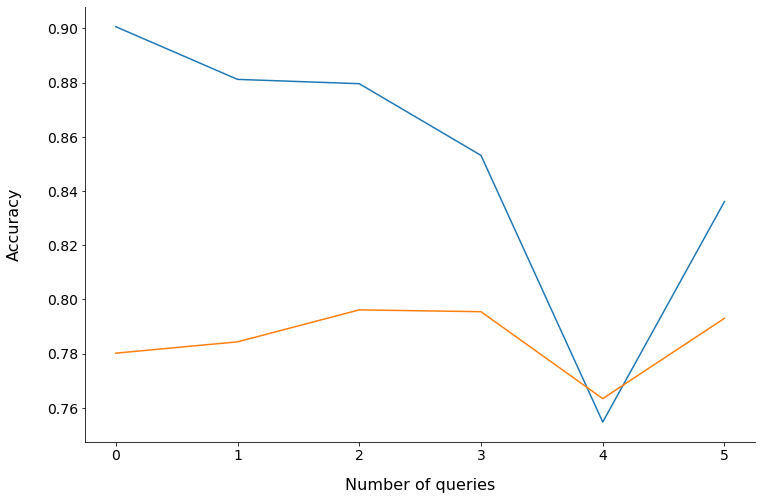

In [37]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

train_data = np.vstack((np.arange(num_queries+1), np.array(train_acc)))
val_data = np.vstack((np.arange(num_queries+1), np.array(val_acc)))
sns.lineplot(x=0, y=1, data=train_data)
sns.lineplot(x=0, y=1, data=val_data)

plt.xlabel('Number of queries', labelpad=15)
plt.ylabel('Accuracy', labelpad=25)

sns.despine()

In [32]:
# pickling the model
import pickle

filename = '/content/drive/MyDrive/Capstone Project/Models/AL2.sav'

In [38]:
pickle.dump(active_learner.classifier, open(filename, 'wb'))

In [33]:
al_model = pickle.load(open(filename, 'rb'))

In [34]:
y_pred_test = al_model.predict(test)
print(len(y_pred_test))

200842


In [35]:
y_pred_test_le = le.inverse_transform(y_pred_test)

In [36]:
test_set = test_set.assign(Bully = y_pred_test_le)

In [37]:
test_set.head()

,OG_Text,Bully,Clean_Text,Preprocessed_Text
0,asl?,Sexism,age sex and location?,locat
1,And you are a perv?,Aggression,And you are a perv?,perv
2,&quot;the list&quot; being public-html,Sexism,&quot;the list&quot; being public-html,quot list quot public-html
3,sure,Negative,sure,sure
4,bugmail: [Bug 7199] microformat &lt;http://lis...,Negative,bugmail: [Bug 7199] microformat &lt;http://lis...,bugmail 7199 microformat http //lists.w3.org/a...


In [38]:
len(test_set)

200842

In [39]:
test_set.Bully.value_counts()

Negative      139795
Sexism         46831
Aggression      6271
Toxic           4834
None            3111
Name: Bully, dtype: int64

In [40]:
filename='/content/drive/MyDrive/Capstone Project/Data/Predictions.csv'
test_set.to_csv(filename, index = False, encoding='utf-8')

# To be uncommented when we need to extract unannotated data after everything is done and more labelled data is needed

In [41]:
#new annotations
new_annotations= pd.read_csv('/content/drive/MyDrive/Capstone Project/Data/Predictions.csv')

In [ ]:
#new_annotations['Bully'] = le.transform(new_annotations['Bully'])

In [52]:
new_annotations['Bully'].value_counts()

Negative      139795
Sexism         46831
Aggression      6271
Toxic           4834
None            3111
Name: Bully, dtype: int64

## Modified Annotated

In [43]:
#extracting only based on "None" annotation count
pre = new_annotations.loc[new_annotations['Bully']=='None']
pre_count=len(pre)

#extracting relevant tweets same as the size of rel
tox = new_annotations.loc[new_annotations['Bully']=='Negative']
tox = tox.iloc[:pre_count]

agg = new_annotations.loc[new_annotations['Bully']=='Sexism']
agg = agg.iloc[:pre_count]

sxm = new_annotations.loc[new_annotations['Bully']=='Toxic']
sxm = sxm.iloc[:pre_count]

rac = new_annotations.loc[new_annotations['Bully']=='Aggression']
rac = rac.iloc[:pre_count]

mis = new_annotations.loc[new_annotations['Bully']=='Racism']
mis = mis.iloc[:pre_count]

none = new_annotations.loc[new_annotations['Bully']=='Misconduct']
none = none.iloc[:pre_count]

In [49]:
#adding to training set
Annotated = pd.concat([Annotated, pre, tox, agg, sxm, rac, mis, none], axis=0)

In [56]:
len(Annotated)

1007071

In [54]:
filename='/content/drive/MyDrive/Capstone Project/Data/Annotated.csv'
Annotated.to_csv(filename, index = False, encoding='utf-8')

## Modified Not Annotated

In [ ]:
#extracting only relevant tweets
pre = new_annotations.loc[new_annotations['Bully']=='None']
pre_count=len(pre)
pre = pre[pre_count:]

#extracting relevant tweets same as the size of rel
tox = new_annotations.loc[new_annotations['Bully']=='Negative']
tox = tox.iloc[pre_count:]

agg = new_annotations.loc[new_annotations['Bully']=='Sexism']
agg = agg.iloc[pre_count:]

sxm = new_annotations.loc[new_annotations['Bully']=='Toxic']
sxm = sxm.iloc[pre_count:]

rac = new_annotations.loc[new_annotations['Bully']=='Aggression']
rac = rac.iloc[pre_count:]

mis = new_annotations.loc[new_annotations['Bully']=='Racism']
mis = mis.iloc[pre_count:]

none = new_annotations.loc[new_annotations['Bully']=='Misconduct']
none = none.iloc[pre_count:]

In [ ]:
NotAnnotated = pd.concat([pre, tox, agg, sxm, rac, mis, none], axis=0)

In [55]:
len(NotAnnotated)

0


In [ ]:
NotAnnotated['Bully'].isna().sum()

0

In [ ]:
filename='/content/drive/MyDrive/Capstone Project/Data/NOT_Annotated.csv'
NotAnnotated.to_csv(filename, index = False, encoding='utf-8')